# Trabalho Prático 1 - Classificação de Spam
Autor: Jorge Augusto de Lima e Silva <br>
Universidade Federal de Minas Gerais <br>
Disciplina: Cybersegurança - DCC030TZ Ano: 2023-1

In [1]:
# Executar o seguinte comando para baixar as bibliotecas necessárias
# %pip install -r requirements.txt

### Import das bibliotecas comuns a todos os classificadores

In [2]:
import regex as re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve
import matplotlib.pyplot as plt
import spacy
import string

# Pré-Processamento dos Dados

Leitura do arquivo de entrada contendo os dados a serem classificados

In [3]:
df = pd.read_csv("spam.csv", encoding = "ISO-8859-1", usecols=[0,1], skiprows=1, names=["label", "message"])
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Substituição da variável que indica se uma mensagem é legítima ou spam por um indicador binário que cumpre o mesmo propósito

In [4]:
df.label = df.label.map({'ham': 0, 'spam': 1})
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Noção sobre o balanceamento das classes

In [5]:
df['label'].value_counts()

label
0    4825
1     747
Name: count, dtype: int64

## Vetorização da mensagem

Uso do modelo pré-treinado glove-twitter-200.

In [6]:
# import gensim.downloader as api
# wv = api.load('glove-twitter-200')
# wv.save('vectors.kv')

Caso for executar mais de uma vez e modelo e não deseje ficar realizando o load todo momento use o save da útlima célula e, na próxima execução comente a célula acima e descomente a de baixo

In [7]:
from gensim.models import KeyedVectors
wv = KeyedVectors.load('vectors.kv')

O vetor de uma mensagem é obtido ao tirarmos as médias dos vetores de palavras da mensagem.

In [8]:
def sent_vec(sent):
    vector_size = wv.vector_size
    wv_res = np.zeros(vector_size)
    # print(wv_res)
    ctr = 1
    for w in sent:
        if w in wv:
            ctr += 1
            wv_res += wv[w]
    wv_res = wv_res/ctr
    return wv_res

Transforma uma mensagem em uma sequência de palavras prontas para serem vetorizadas

In [9]:
nlp = spacy.load("en_core_web_sm")
punctuations = string.punctuation
def spacy_tokenizer(sentence):
    doc = nlp(sentence)
    mytokens = [ word.lemma_.lower().strip() for word in doc ]
    mytokens = [ word for word in mytokens if word not in punctuations ]
    return mytokens

Transformação das mensagens em vetores

In [10]:
df['tokens'] = df['message'].apply(spacy_tokenizer)
df['vec'] = df['tokens'].apply(sent_vec)

In [11]:
X = np.array(df['vec'].to_list())
y = np.array(df['label'].to_list())

Uma ideia da distribuição dos dados no espaço

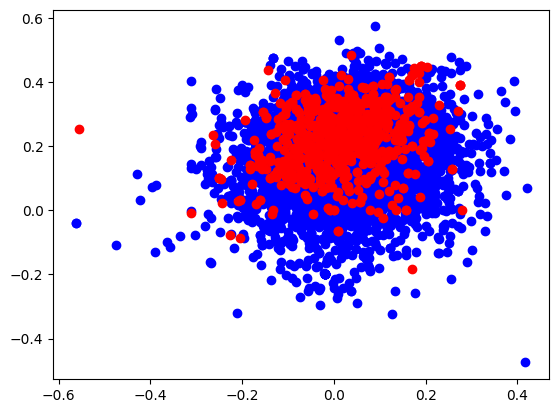

In [12]:
from sklearn.manifold import TSNE
tsen = TSNE()
X_new = tsen.fit_transform(X)
plt.scatter(X[np.where(y == 0),0], X[np.where(y == 0),1], color='blue')
plt.scatter(X[np.where(y == 1),0], X[np.where(y == 1),1], color='red')
plt.show()

### Divisão dos dados em conjuntos de treino e teste

In [13]:
# X, y = data[:,:-1], data[:,-1]
# y = y.astype(np.int64)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4457, 200) (4457,)
(1115, 200) (1115,)


In [15]:
rank = {}

## Os Modelos e seu Resultados

### Regressão Logística

Acurácia:  0.9713004484304932
Precisão:  0.9090909090909091
Recall:  0.8571428571428571
[[963  12]
 [ 20 120]]


/Users/jorgesilva/workspace/ufmg/2023-1/cyberseguranca/Projeto1_1/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


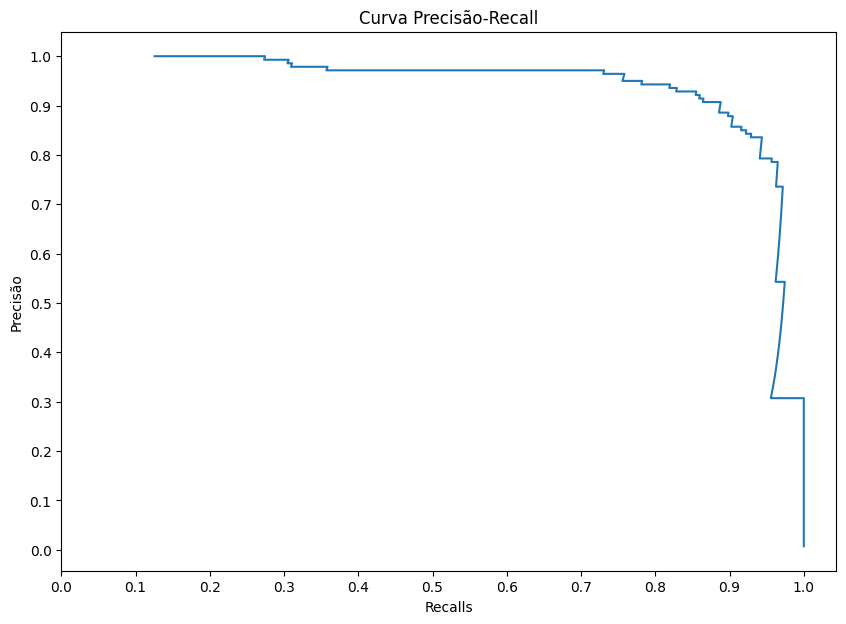

In [16]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
lr_acc = accuracy_score(y_true=y_test, y_pred=y_pred)
lr_pre = precision_score(y_true=y_test, y_pred=y_pred)
lr_rec = recall_score(y_true=y_test, y_pred=y_pred)
print('Acurácia: ', lr_acc)
print('Precisão: ', lr_pre)
print('Recall: ', lr_rec)
rank['Logistic Regression'] = lr_acc
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
print(cm)
labels_prob = logreg.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, labels_prob)
plt.figure(figsize=(10, 7))
plt.plot(precisions[:-1], recalls[:-1])
plt.xlabel("Recalls")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Precisão")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Curva Precisão-Recall")
plt.show()

### Floresta Aleatória

Acurácia:  0.9766816143497757
Precisão:  0.9913793103448276
Recall:  0.8214285714285714
[[974   1]
 [ 25 115]]


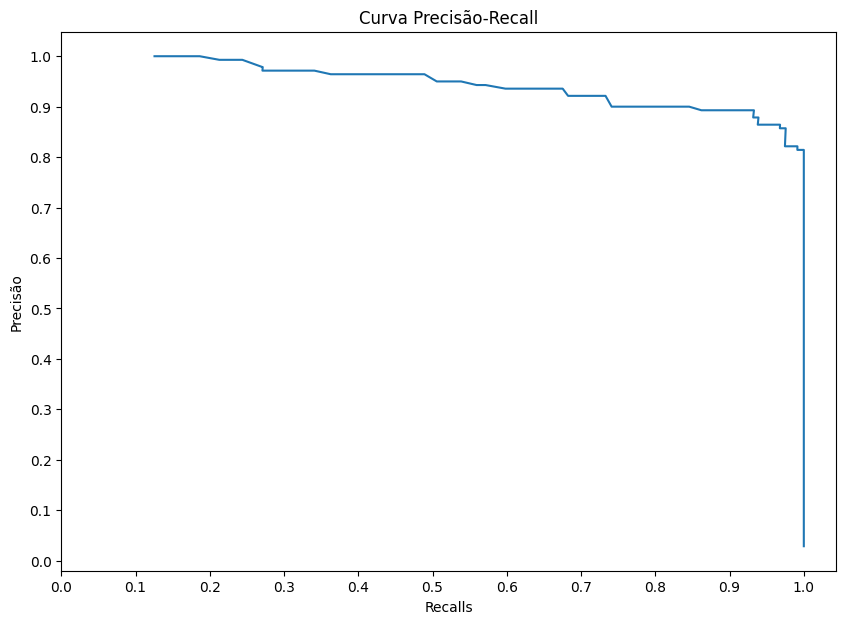

In [17]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_true=y_test, y_pred=y_pred)
rf_pre = precision_score(y_true=y_test, y_pred=y_pred)
rf_rec = recall_score(y_true=y_test, y_pred=y_pred)
print('Acurácia: ', rf_acc)
print('Precisão: ', rf_pre)
print('Recall: ', rf_rec)
rank['Random Forest'] = rf_acc
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
print(cm)
labels_prob = rf.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, labels_prob)
plt.figure(figsize=(10, 7))
plt.plot(precisions[:-1], recalls[:-1])
plt.xlabel("Recalls")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Precisão")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Curva Precisão-Recall")
plt.show()

### Support Vector Machine

In [18]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
svm_acc = accuracy_score(y_true=y_test, y_pred=y_pred)
svm_pre = precision_score(y_true=y_test, y_pred=y_pred)
svm_rec = recall_score(y_true=y_test, y_pred=y_pred)
print('Acurácia: ', svm_acc)
print('Precisão: ', svm_pre)
print('Recall: ', svm_rec)
rank['SVM'] = svm_acc
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
print(cm)

Acurácia:  0.9757847533632287
Precisão:  0.9448818897637795
Recall:  0.8571428571428571
[[968   7]
 [ 20 120]]


### Multi-Layer Perceptron

/Users/jorgesilva/workspace/ufmg/2023-1/cyberseguranca/Projeto1_1/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Acurácia:  0.9721973094170404
Precisão:  0.8865248226950354
Recall:  0.8928571428571429
[[959  16]
 [ 15 125]]


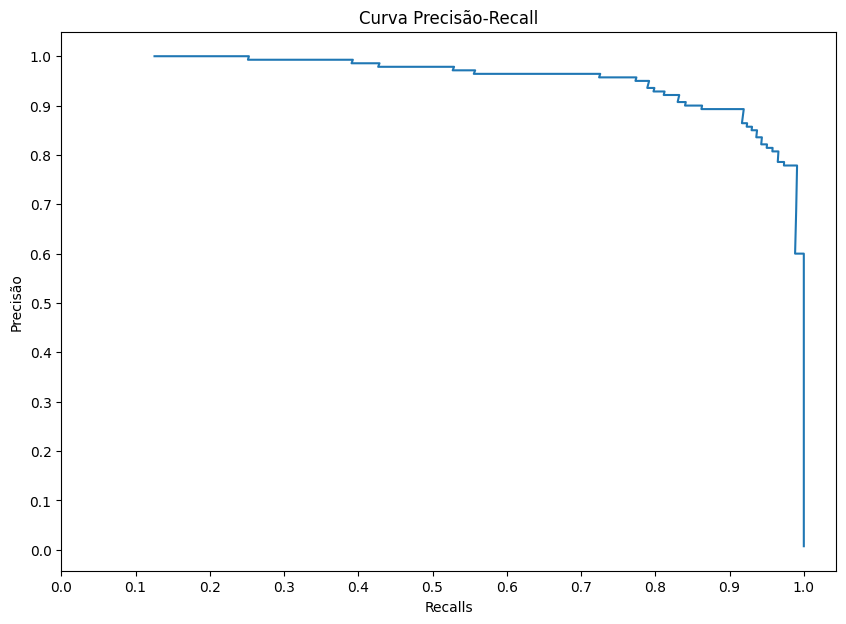

In [19]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(activation='logistic', solver='adam', learning_rate='adaptive', hidden_layer_sizes=(100,50), alpha=0.0001)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
mlp_acc = accuracy_score(y_true=y_test, y_pred=y_pred)
mlp_pre = precision_score(y_true=y_test, y_pred=y_pred)
mlp_rec = recall_score(y_true=y_test, y_pred=y_pred)
print('Acurácia: ', mlp_acc)
print('Precisão: ', mlp_pre)
print('Recall: ', mlp_rec)
rank['MLP'] = mlp_acc
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
print(cm)
labels_prob = mlp.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, labels_prob)
plt.figure(figsize=(10, 7))
plt.plot(precisions[:-1], recalls[:-1])
plt.xlabel("Recalls")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Precisão")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Curva Precisão-Recall")
plt.show()

### Adaptive Boosting

Acurácia:  0.9739910313901345
Precisão:  0.9051094890510949
Recall:  0.8857142857142857
[[962  13]
 [ 16 124]]


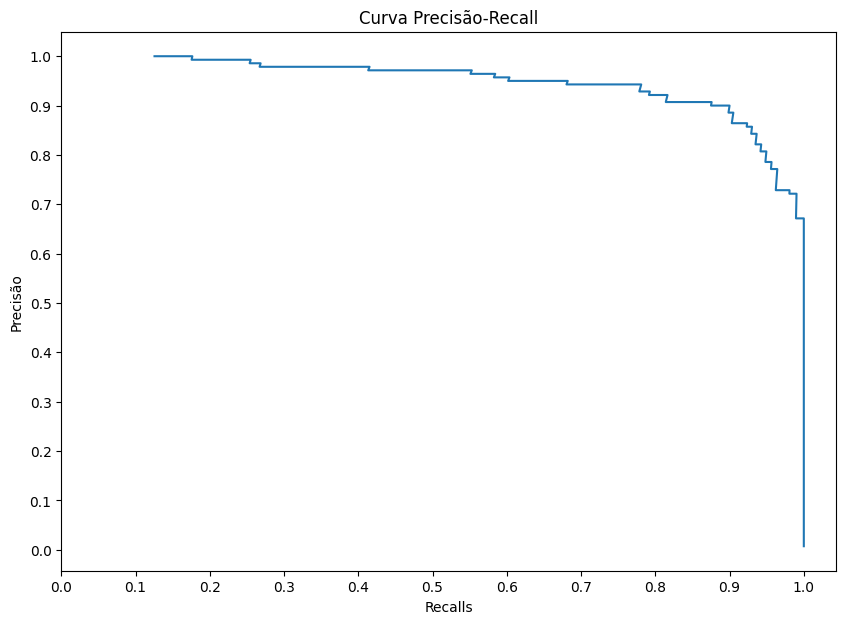

In [20]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
ada_acc = accuracy_score(y_true=y_test, y_pred=y_pred)
ada_pre = precision_score(y_true=y_test, y_pred=y_pred)
ada_rec = recall_score(y_true=y_test, y_pred=y_pred)
print('Acurácia: ', ada_acc)
print('Precisão: ', ada_pre)
print('Recall: ', ada_rec)
rank['AdaBoost'] = ada_acc
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
print(cm)
labels_prob = ada.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, labels_prob)
plt.figure(figsize=(10, 7))
plt.plot(precisions[:-1], recalls[:-1])
plt.xlabel("Recalls")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Precisão")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Curva Precisão-Recall")
plt.show()

## Ranking Comparando a Acurácia dos Classificadores

In [21]:
dict(sorted(rank.items(), key=lambda x: x[1])[::-1])

{'Random Forest': 0.9766816143497757,
 'SVM': 0.9757847533632287,
 'AdaBoost': 0.9739910313901345,
 'MLP': 0.9721973094170404,
 'Logistic Regression': 0.9713004484304932}